In [1]:
import os
from PIL import Image
import numpy as np
import cv2
from image_transformer import ImageTransformer
import matplotlib.pyplot as plt

In [2]:
def scale_rotate_img(image, theta_range=(-30, 30), phi_range=(-30, 30), gamma_range=(-15, 15), scale_min=0.4, scale_max=0.8):
    random_theta = np.random.randint(theta_range[0], theta_range[1] + 1)
    random_phi = np.random.randint(phi_range[0], phi_range[1] + 1)
    random_gamma = np.random.randint(gamma_range[0], gamma_range[1] + 1)
    print(random_theta, random_phi, random_gamma)
    it = ImageTransformer(image)
    im = it.rotate_along_axis(theta=random_theta, phi=random_phi, gamma=random_gamma, dx=0, dy=0, dz=0)
    img = Image.fromarray(cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)) 
    
    random_resize = np.random.randint(scale_min * 10, (scale_max + 0.1) * 10)
    random_resize = random_resize / 10
    origin_size = img.size[0]
    scaled_size = int(origin_size * random_resize)
    
    img = img.resize((scaled_size, scaled_size), Image.ANTIALIAS)
    return img

In [3]:
def merge_two_imgs(foreground_imgs, background_imgs, result_img):
    background = Image.open(background_imgs)
    foreground = scale_rotate_img(foreground_imgs)
    
    paste_x = np.random.randint(0, background.size[0] - foreground.size[0])
    paste_y = np.random.randint(0, background.size[1] - foreground.size[1])
    
    background.paste(foreground, (paste_x, paste_y), foreground)
    plt.axis('off')
    plt.imshow(background)
    plt.show()
    background.save(result_img, "PNG")

24 -9 -11


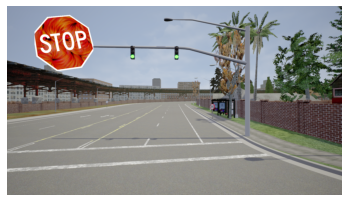

-6 -10 -1


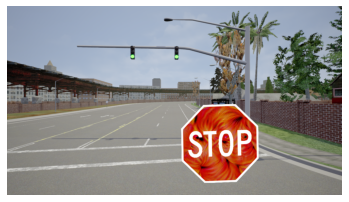

24 22 -12


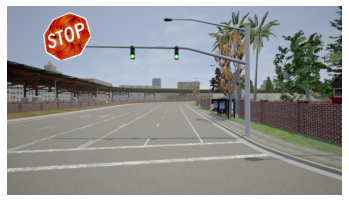

19 23 12


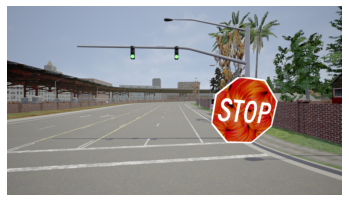

3 10 -12


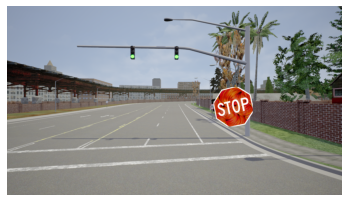

25 23 -2


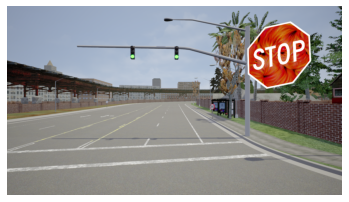

-29 29 -12


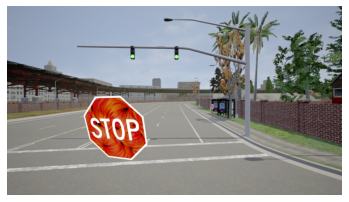

-22 -3 5


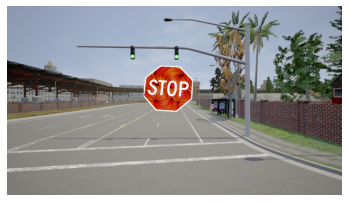

22 10 14


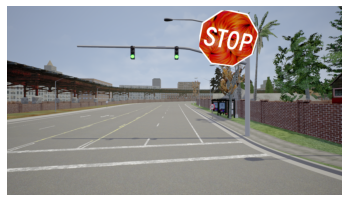

-5 13 4


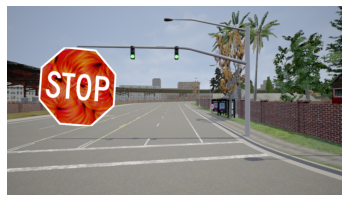

In [4]:
for i in range(10):
    result_file_folder = '3d_rotate_samples_for_stop3' 
    result_file_path = os.path.join(result_file_folder, 'b2_{}.png'.format(i))
    merge_two_imgs('./stop3.png', 'data/background2.png', result_file_path)

In [4]:
def find_coeffs(source_coords, target_coords):
    matrix = []
    for s, t in zip(source_coords, target_coords):
        matrix.append([t[0], t[1], 1, 0, 0, 0, -s[0]*t[0], -s[0]*t[1]])
        matrix.append([0, 0, 0, t[0], t[1], 1, -s[1]*t[0], -s[1]*t[1]])
    A = np.matrix(matrix, dtype=np.float)
    B = np.array(source_coords).reshape(8)
    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)

[  1.08508331   0.62647314 -69.23346685  -0.62647314   1.08508331
 118.70847489   0.           0.        ]


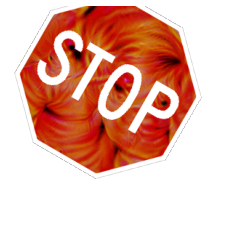

In [65]:
import math
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

def get_M(width, height, focal, theta, phi, gamma, dx, dy, dz):
        
        w = width
        h = height
        f = focal

        # Projection 2D -> 3D matrix
        A1 = np.array([ [1, 0, -w/2],
                        [0, 1, -h/2],
                        [0, 0, 1],
                        [0, 0, 1]])
        
        # Rotation matrices around the X, Y, and Z axis
        RX = np.array([ [1, 0, 0, 0],
                        [0, np.cos(theta), -np.sin(theta), 0],
                        [0, np.sin(theta), np.cos(theta), 0],
                        [0, 0, 0, 1]])
        
        RY = np.array([ [np.cos(phi), 0, -np.sin(phi), 0],
                        [0, 1, 0, 0],
                        [np.sin(phi), 0, np.cos(phi), 0],
                        [0, 0, 0, 1]])
        
        RZ = np.array([ [np.cos(gamma), -np.sin(gamma), 0, 0],
                        [np.sin(gamma), np.cos(gamma), 0, 0],
                        [0, 0, 1, 0],
                        [0, 0, 0, 1]])

        # Composed rotation matrix with (RX, RY, RZ)
        R = np.dot(np.dot(RX, RY), RZ)

        # Translation matrix
        T = np.array([  [1, 0, 0, dx],
                        [0, 1, 0, dy],
                        [0, 0, 1, dz],
                        [0, 0, 0, 1]])

        # Projection 3D -> 2D matrix
        A2 = np.array([ [f, 0, w/2, 0],
                        [0, f, h/2, 0],
                        [0, 0, 1, 0]])

        # Final transformation matrix
        return np.dot(A2, np.dot(T, np.dot(R, A1)))

def get_transform3d(origin, x_shift, y_shift, im_scale, yaw, pitch, roll):
    theta = float(yaw) * math.pi / 180.0
    phi = float(pitch) * math.pi / 180.0
    gamma = float(roll) * math.pi / 180.0

    x_origin, y_origin = origin
    d = np.sqrt((x_origin*2)**2 + (y_origin*2)**2)
    focal = d / (2 * np.sin(gamma) if np.sin(gamma) != 0 else 1)
    mat = get_M(x_origin * 2, y_origin * 2, focal, theta, phi, gamma, x_shift, y_shift, focal)
    mat = np.dot(mat, [[im_scale, 0, 0], [0, im_scale, 0], [0, 0, 1]])
    inv_mat = np.linalg.inv(mat)
    
    return (inv_mat.reshape(9, ) / inv_mat[2, 2])[:8]

    #a0, a1, a2 = mat[0][0] / mat[2][2], mat[0][1] / mat[2][2], mat[0][2] / mat[2][2]
    #b0, b1, b2 = mat[1][0] / mat[2][2], mat[1][1] / mat[2][2], mat[1][2] / mat[2][2]
    #c0, c1 = mat[2][0] / mat[2][2], mat[2][1] / mat[2][2]

    #return np.linalg.inv(np.array([a0, a1, a2, b0, b1, b2, c0, c1]).astype(np.float32))
    #eturn np.array([a0, a1, a2, b0, b1, b2, c0, c1]).astype(np.float32)

img = Image.open('./stop3.png')
output_width, output_height = img.size
origin = (output_width // 2, output_height // 2)
transform = get_transform3d(origin, 0, 0, 0.8, 0, 0, 30)
print(transform)

transformed_mask_img = Image.new('RGBA', (output_width, output_height), (0))
transformed_mask_img.paste(img, (0, 0), img)
transformed_mask_img = transformed_mask_img.transform((output_width, output_height), Image.PERSPECTIVE, transform, Image.BILINEAR)
plt.axis('off')
plt.imshow(transformed_mask_img)
plt.show()


#input = tf.placeholder(dtype=np.uint8,shape=[output_width,output_height,4]) 
#trans_op = tf.contrib.image.transform(input, transform)
#img = cv2.imread('./stop3.png', cv2.IMREAD_UNCHANGED)
#img = cv2.imread('./stop3.png')
#with tf.Session() as sess:
    #trans_img=sess.run(trans_op, feed_dict={input:img})
    #plt.axis('off')
    #plt.imshow(trans_img)

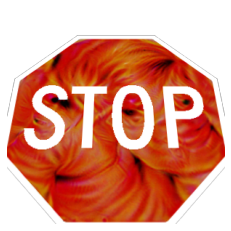

In [56]:
import cv2
from image_transformer import ImageTransformer
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

it = ImageTransformer('./stop3.png')
im = it.rotate_along_axis(theta=-30, phi=0, gamma=0, dx=0, dy=0, dz=0)
image = Image.fromarray(cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)) 

plt.axis('off')
plt.imshow(image)
plt.show()